In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# **About Dataset**
The Dataset contains data for 5 years ie. from 5th Feb 2018 to 5th Feb 2022

The art of forecasting stock prices has been a difficult task for many of the researchers and analysts. In fact, investors are highly interested in the research area of stock price prediction. For a good and successful investment, many investors are keen on knowing the future situation of the stock market. Good and effective prediction systems for the stock market help traders, investors, and analyst by providing supportive information like the future direction of the stock market.

Source: https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction/data

# **Data Loading**

In [3]:
df = pd.read_csv("./netflix-data.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [6]:
df.drop(columns = ['Adj Close', 'Open', 'High', 'Low', 'Volume'], inplace=True)

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

In [8]:
df = df.sort_index()
df.head()

,Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001


In [9]:
px.line(df, x=df.index, y='Close', title='Netflix Stock Price Over Time')

# **Checking stationarity using the ADF test**

In [10]:
adf_test = adfuller(df['Close'])
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

adf_result

{'ADF Statistic': -1.8125906878289955,
 'p-value': 0.3742289256820759,
 'Critical Values': {'1%': -3.436893045520188,
  '5%': -2.8644287878535146,
  '10%': -2.568308127138936}}

Since the p-value > 0.05, the series is non-stationary, meaning it has trends or seasonality. I'll apply first-order differencing to make it stationary and recheck with the ADF test.

In [11]:
df['Close_diff'] = df['Close'].diff()
adf_test_diff = adfuller(df['Close_diff'].dropna())

print("ADF Statistic:", adf_test_diff[0])
print("p-value:", adf_test_diff[1])
print("Critical Values:", adf_test_diff[4])

ADF Statistic: -14.24227599292912
p-value: 1.5304022754298515e-26
Critical Values: {'1%': -3.436893045520188, '5%': -2.8644287878535146, '10%': -2.568308127138936}


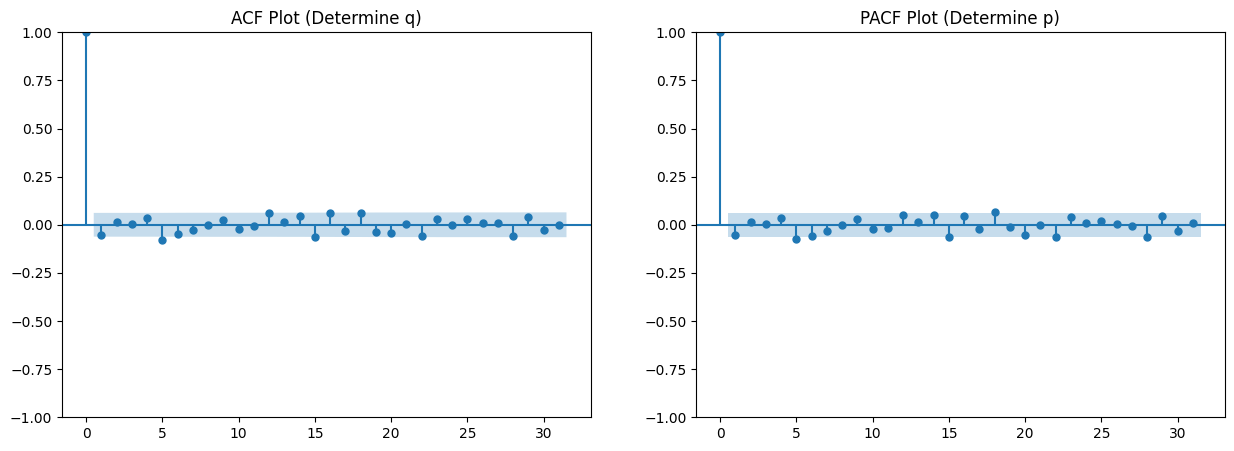

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df['Close_diff'].dropna(), ax=axes[0])  # Determines q
plot_pacf(df['Close_diff'].dropna(), ax=axes[1])  # Determines p
axes[0].set_title("ACF Plot (Determine q)")
axes[1].set_title("PACF Plot (Determine p)")
plt.show()

From this, number of lags for MA = 7, Ar = 7

We can now find optimal values for p and q.

In [20]:
for i in range(1,7):
    for j in range(1,7):
        model=ARIMA(df['Close'],order=(i,0,j))
        result=model.fit()
        print(f"AIC :{result.aic}, Order Of AR: {i}, Order of MA:{j} ")

AIC :7719.252725378626, Order Of AR: 1, Order of MA:1 
AIC :7720.890983924168, Order Of AR: 1, Order of MA:2 
AIC :7722.748629701169, Order Of AR: 1, Order of MA:3 
AIC :7723.68576188463, Order Of AR: 1, Order of MA:4 
AIC :7718.415482131526, Order Of AR: 1, Order of MA:5 
AIC :7718.172317914759, Order Of AR: 1, Order of MA:6 
AIC :7719.876850429353, Order Of AR: 2, Order of MA:1 
AIC :7723.251351789884, Order Of AR: 2, Order of MA:2 
AIC :7724.6740173066555, Order Of AR: 2, Order of MA:3 
AIC :7723.762865540199, Order Of AR: 2, Order of MA:4 
AIC :7718.287566398099, Order Of AR: 2, Order of MA:5 
AIC :7720.069487586208, Order Of AR: 2, Order of MA:6 
AIC :7721.431344434819, Order Of AR: 3, Order of MA:1 
AIC :7714.7389103751475, Order Of AR: 3, Order of MA:2 
AIC :7725.176500010285, Order Of AR: 3, Order of MA:3 
AIC :7720.359601613189, Order Of AR: 3, Order of MA:4 
AIC :7719.970658334276, Order Of AR: 3, Order of MA:5 
AIC :7722.088940674155, Order Of AR: 3, Order of MA:6 
AIC :7723

# Model Training and Prediction

In [21]:
model = ARIMA(df['Close'], order=(6, 1, 6))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.361
Date:                Wed, 19 Feb 2025   AIC                           7702.723
Time:                        14:52:15   BIC                           7766.627
Sample:                             0   HQIC                          7727.002
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.065      3.445      0.001       0.096       0.349
ar.L2          0.6265      0.062     10.131      0.000       0.505       0.748
ar.L3         -1.1327      0.069    -16.518      0.0

<Axes: xlabel='Date'>

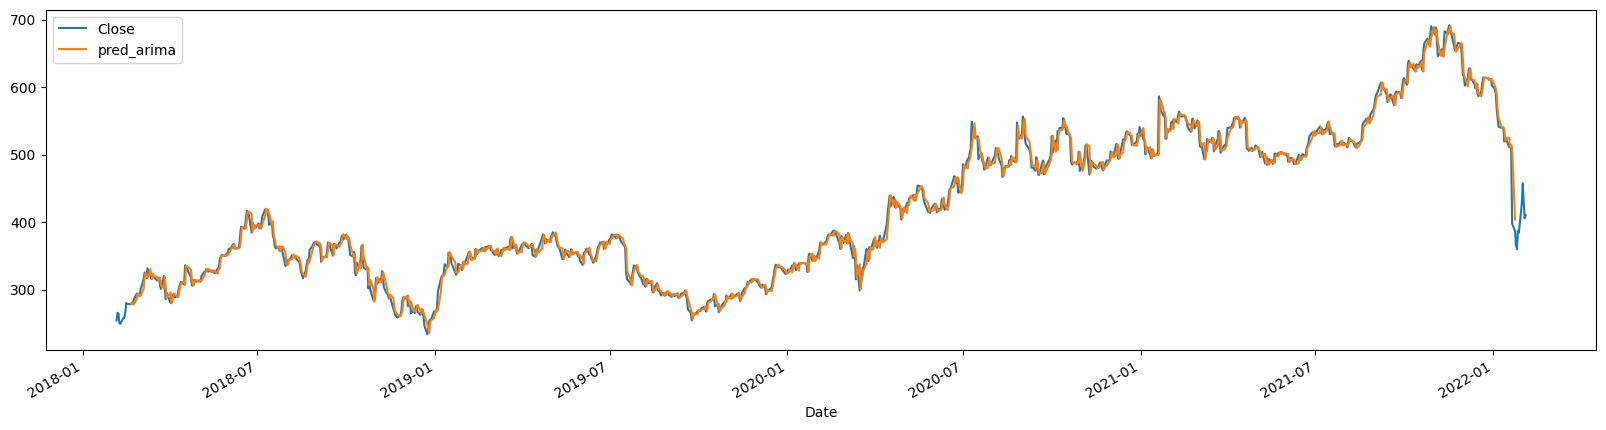

In [45]:
df['pred_arima']=result.predict(start=10,end=999)
df[["Close","pred_arima"]].plot(figsize=(20,5))

In [46]:
forecast_steps = 30  # Predict next month
forecast = model_fit.forecast(steps=forecast_steps)

In [47]:
start_date = '2022-02-05'
end_date = '2022-03-06'
date_range = pd.date_range(start=start_date, end=end_date)

fc_with_dates = pd.Series(forecast.to_numpy(), index=date_range)
print(fc_with_dates)

2022-02-05    408.603822
2022-02-06    400.179374
2022-02-07    393.166354
2022-02-08    391.768230
2022-02-09    396.047945
2022-02-10    398.195215
2022-02-11    398.460530
2022-02-12    399.912785
2022-02-13    406.069384
2022-02-14    411.480072
2022-02-15    411.822233
2022-02-16    407.283751
2022-02-17    403.801981
2022-02-18    402.953014
2022-02-19    401.849564
2022-02-20    397.919795
2022-02-21    394.025416
2022-02-22    394.605042
2022-02-23    398.988595
2022-02-24    403.092388
2022-02-25    403.997304
2022-02-26    404.599176
2022-02-27    406.563883
2022-02-28    409.134056
2022-03-01    407.915085
2022-03-02    403.984647
2022-03-03    399.849844
2022-03-04    399.188864
2022-03-05    399.158203
2022-03-06    398.754460
Freq: D, dtype: float64


In [53]:
fig = px.line()

fig.add_scatter(x=df.index, y=df['Close'], mode='lines', name='Actual Data')
fig.add_scatter(x=fc_with_dates.index, y=fc_with_dates, mode='lines', name='Forecast')

fig.update_layout(title="Netflix Stock Price Forecast",
                  xaxis_title="Date",
                  yaxis_title="Closing Price",
                  template="plotly_white")

fig.show()